In [1]:
import pandas as pd

df_kaon = pd.read_csv('data/v1_kaon_train.csv')
df_kaon.head()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
0,733.720825,7811.620117,40.0,321,5.395000,5.395000,-2.7621,5.395000,-6.4719,3.056173
1,766.389587,13805.900391,29.0,321,32.001301,48.601002,-4.4894,32.001301,-11.0133,3.583537
2,454.289093,4635.049805,32.0,321,17.493500,17.493500,-12.2938,17.493500,-7.7980,3.013405
3,1054.564331,4333.899902,26.0,321,19.676600,19.676600,-7.5441,19.676600,-11.6452,2.091345
4,1975.175537,24745.910156,57.0,-321,20.518400,52.582600,0.0612,10.397500,0.0172,3.219554


In [2]:
x_cols = ['TrackPt', 'TrackP','TrackEta']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

In [3]:
df_kaon[x_cols].shape, df_kaon[y_cols].shape

((999993, 3), (999993, 5))

In [4]:
import torch

latent_dims = 3
dropout_rate = 0.1

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dims, 256),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(256, 5),
    #torch.nn.ELU(),
)#.cuda()

discriminator = torch.nn.Sequential(
    torch.nn.Linear(5, 4),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(4, 1),
)#.cuda()

In [5]:
logsigmoid = torch.nn.functional.logsigmoid

def generator_loss(fake):
    return -torch.mean(logsigmoid(discriminator(fake)))
  
def discriminator_loss(real, fake):
    return -torch.mean(logsigmoid(discriminator(real)))-torch.mean(logsigmoid(-discriminator(fake)))

batch_size = 32

def sample_responses(batch_size):
    ids = np.random.choice(len(df_kaon), size=batch_size)
    return torch.tensor(np.array(df_kaon[y_cols])[ids])#.cuda()

def sample_fake(batch_size):
    noise = torch.randn(batch_size, latent_dims)#.cuda()
    return generator(noise)

generator_losses = []
discriminator_losses = []

optimizer_generator = \
    torch.optim.Adam(generator.parameters())
optimizer_discriminator = \
    torch.optim.SGD(discriminator.parameters(), lr = 0.01, momentum=0.9)

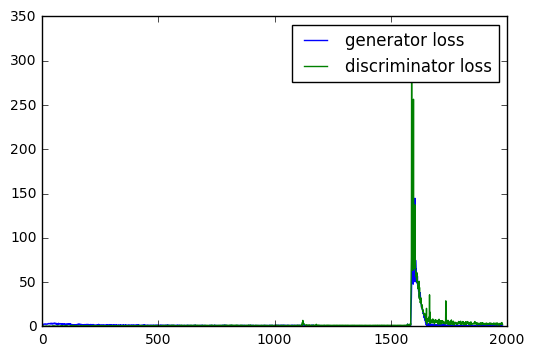

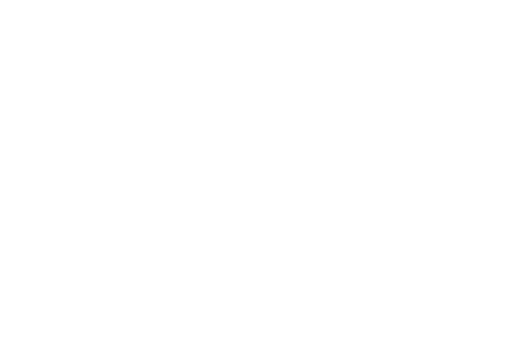

In [6]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(2000):
    # Set our models to training mode:
    generator.train()
    discriminator.train()
  
    # Several discriminator updates per step:
    for j in range(5):
        # Sampling reals and fakes
        real = sample_responses(batch_size)
        fake = sample_fake(batch_size)
        #print(real.shape, fake.shape)
    
        # Calculating the loss
        loss = discriminator_loss(real.float(), fake.float())
    
        # Doing our regular optimization step for the discriminator
        discriminator.zero_grad()
        loss.backward()
        optimizer_discriminator.step()

    # Remember the value of discriminator loss for plotting
    discriminator_losses.append(loss.item())

    # Now it's generator's time to learn:
    loss = generator_loss(sample_fake(batch_size))
    generator_losses.append(loss.item())
    generator.zero_grad()
    loss.backward()
    optimizer_generator.step()
    #scheduler_d.step()
    #scheduler_g.step()

    
    if i % 20 == 0:
        clear_output(wait=True)
        plt.plot(generator_losses    , label='generator loss')
        plt.plot(discriminator_losses, label='discriminator loss')
        plt.legend()
        plt.show()
        generator.eval()
        #imgs = sample_fake(25).cpu().detach().numpy()
        #plt.figure(figsize=(8, 8))
        #plot_mn(imgs.clip(0, 1))
        plt.axis('off')
        plt.show()

In [15]:
#https://github.com/SiLiKhon/RICH_GAN_misc/blob/master/coopetition/scoring_program/score.py

def score_func(sample1, sample2):
    score = 0
    cols = sample1.columns
    w_normal = np.random.normal(size=(100, len(cols)))
    reference = sample1.copy()[cols].values
    #prediction = sample2.copy()[cols].values
    prediction = sample2.copy().values
    for k in range(100):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * reference, axis=1), 
                        np.sum(w_normal[k] * prediction, axis=1)
                    )[0]
                   )
    return score

# kaon

In [16]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

kf = KFold(n_splits=5)

model_scores = []
best_scores  = []

for train_index, test_index in kf.split(df_kaon[x_cols]):
    X_train = df_kaon[x_cols].iloc[train_index]
    Y_train = df_kaon[y_cols].iloc[train_index]
    X_test  = df_kaon[x_cols].iloc[test_index ]
    Y_test  = df_kaon[y_cols].iloc[test_index ]
  
    #model = Model()
    #model.train(X_train.copy(), Y_train.copy(), n_bins=5)
    Y_pred = sample_fake(len(X_test))#model.predict(X_test.copy())
    model_scores.append(score_func(Y_test, pd.DataFrame(Y_pred.detach().numpy())))
    best_scores.append(score_func(Y_test, Y_train))

In [17]:
Y_pred = pd.DataFrame(data=Y_pred.detach().numpy(), columns=y_cols) 

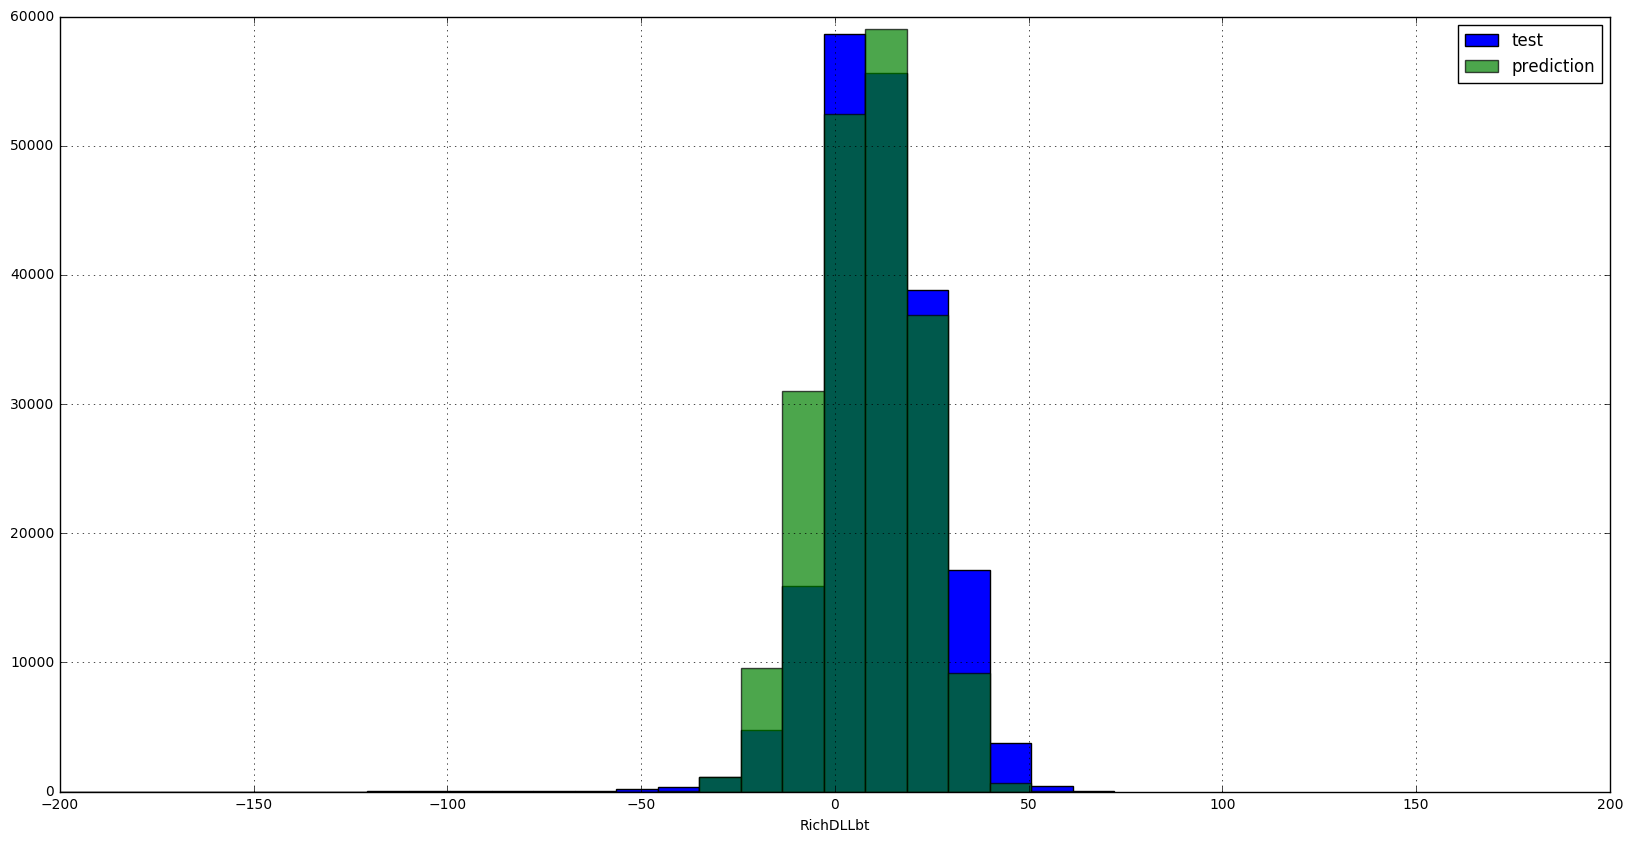

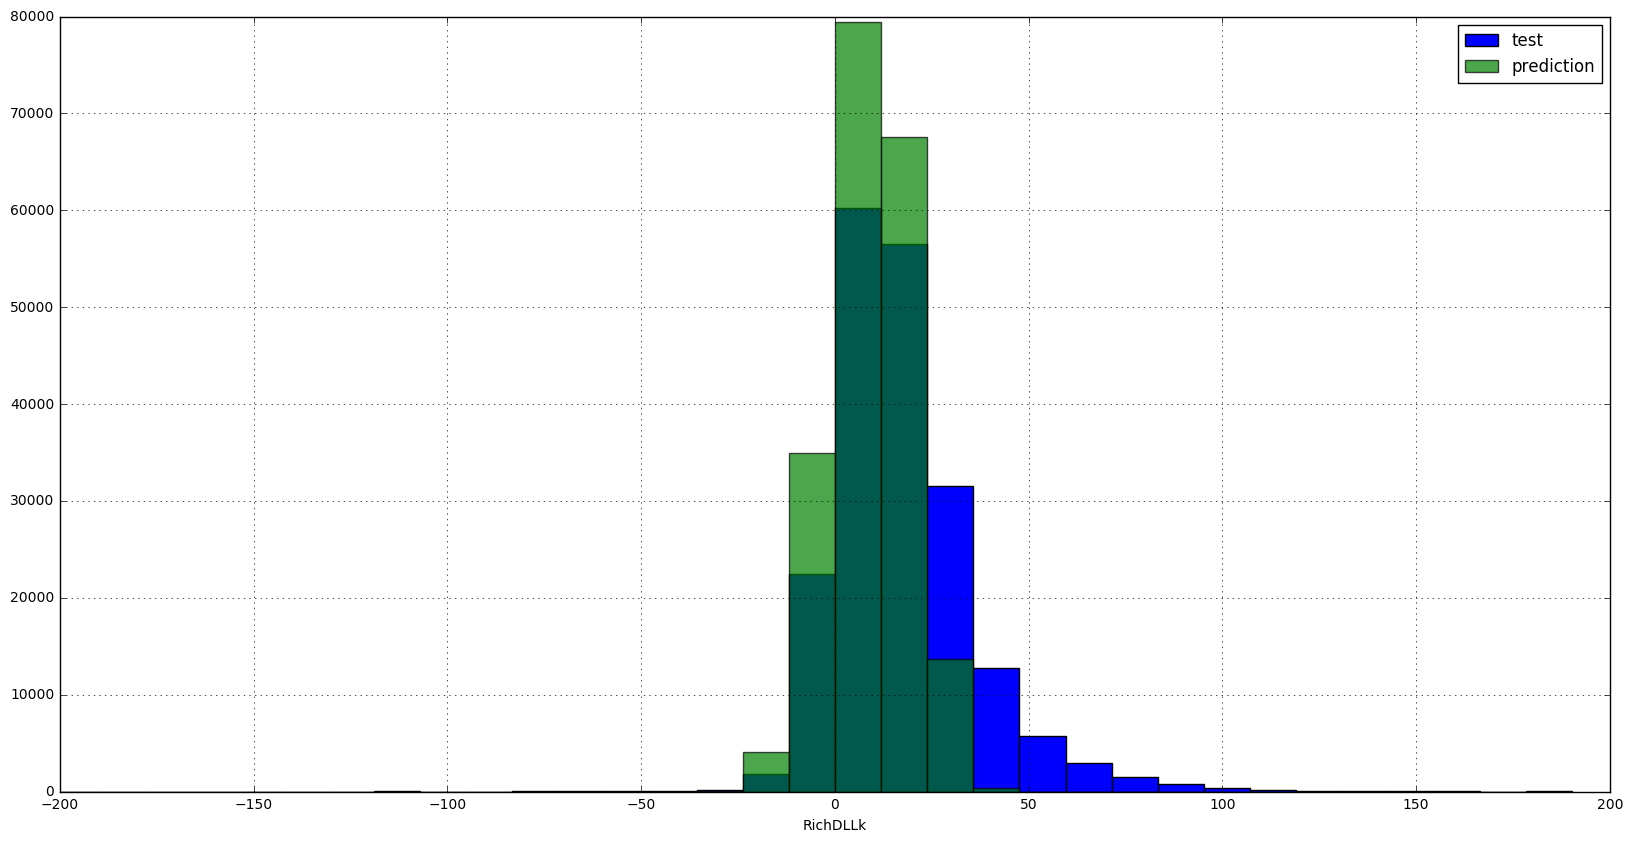

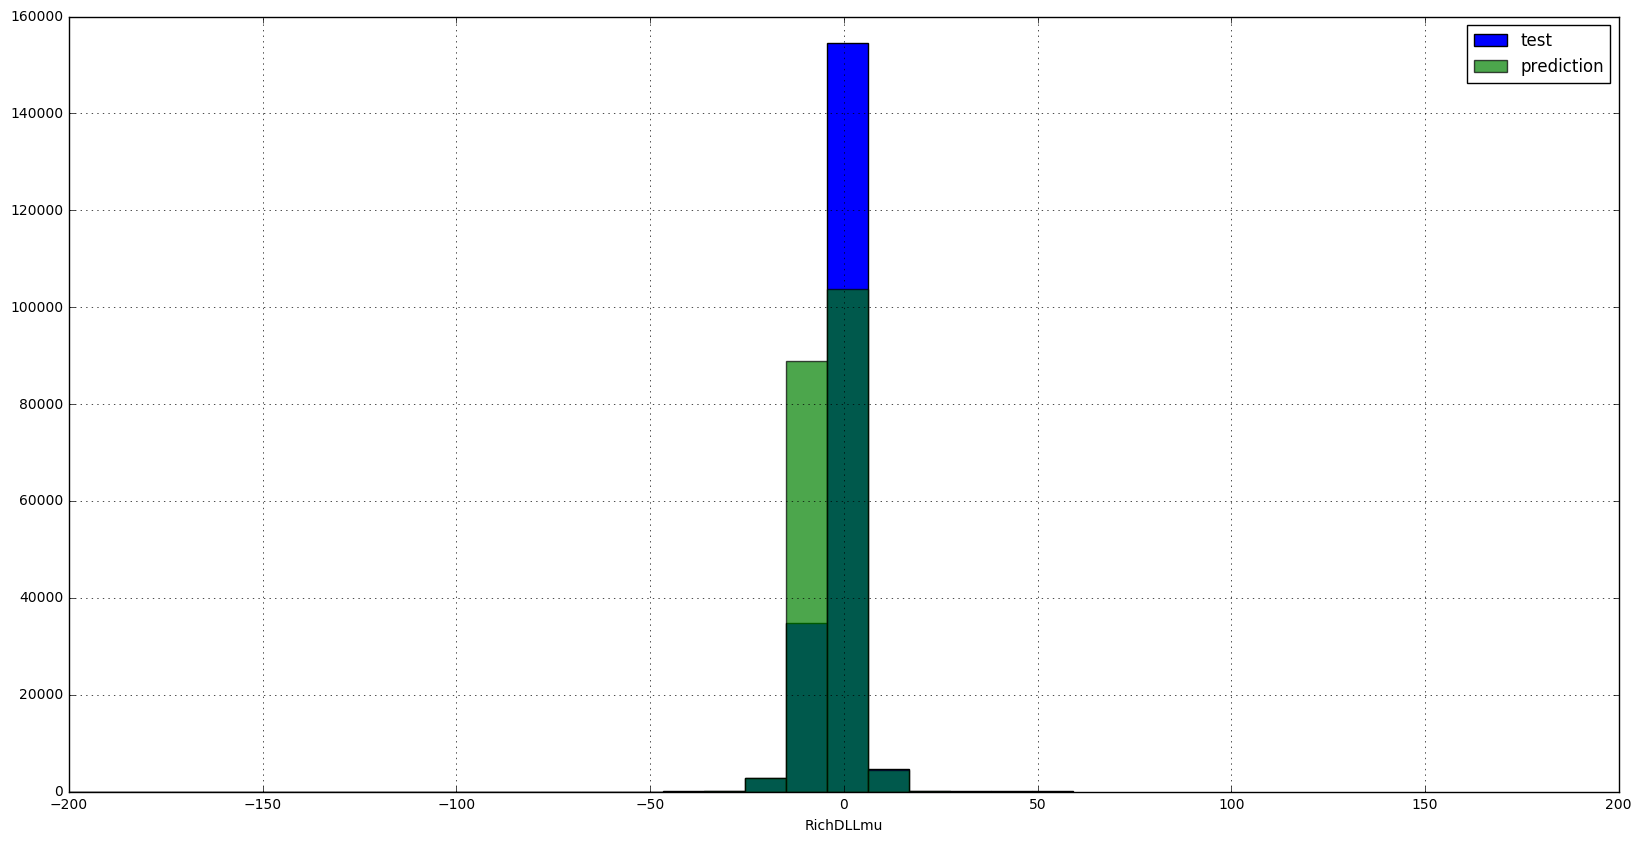

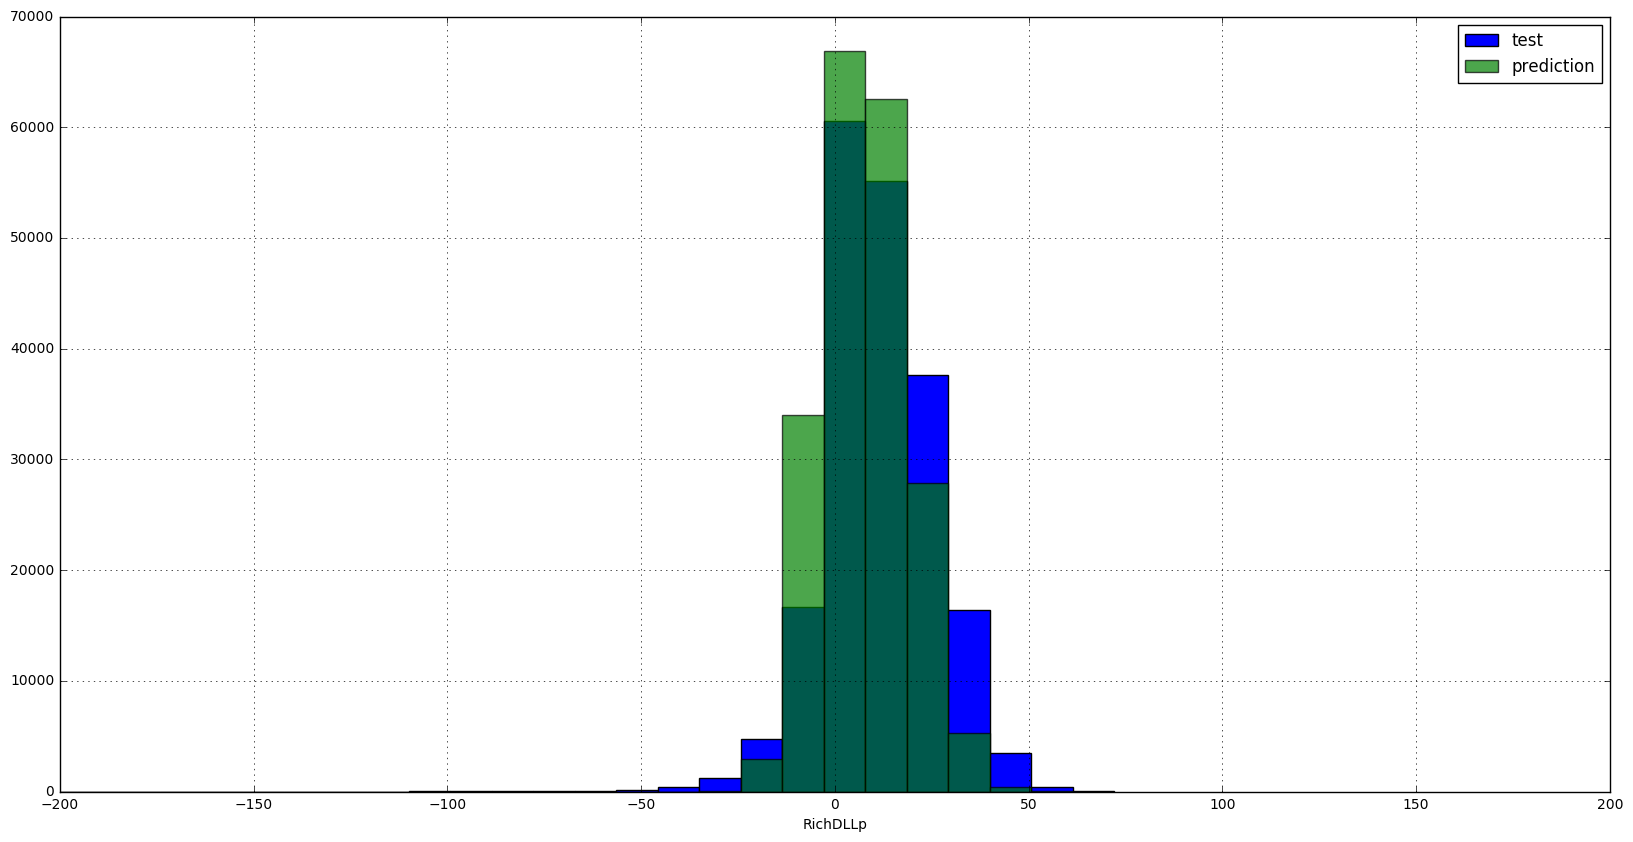

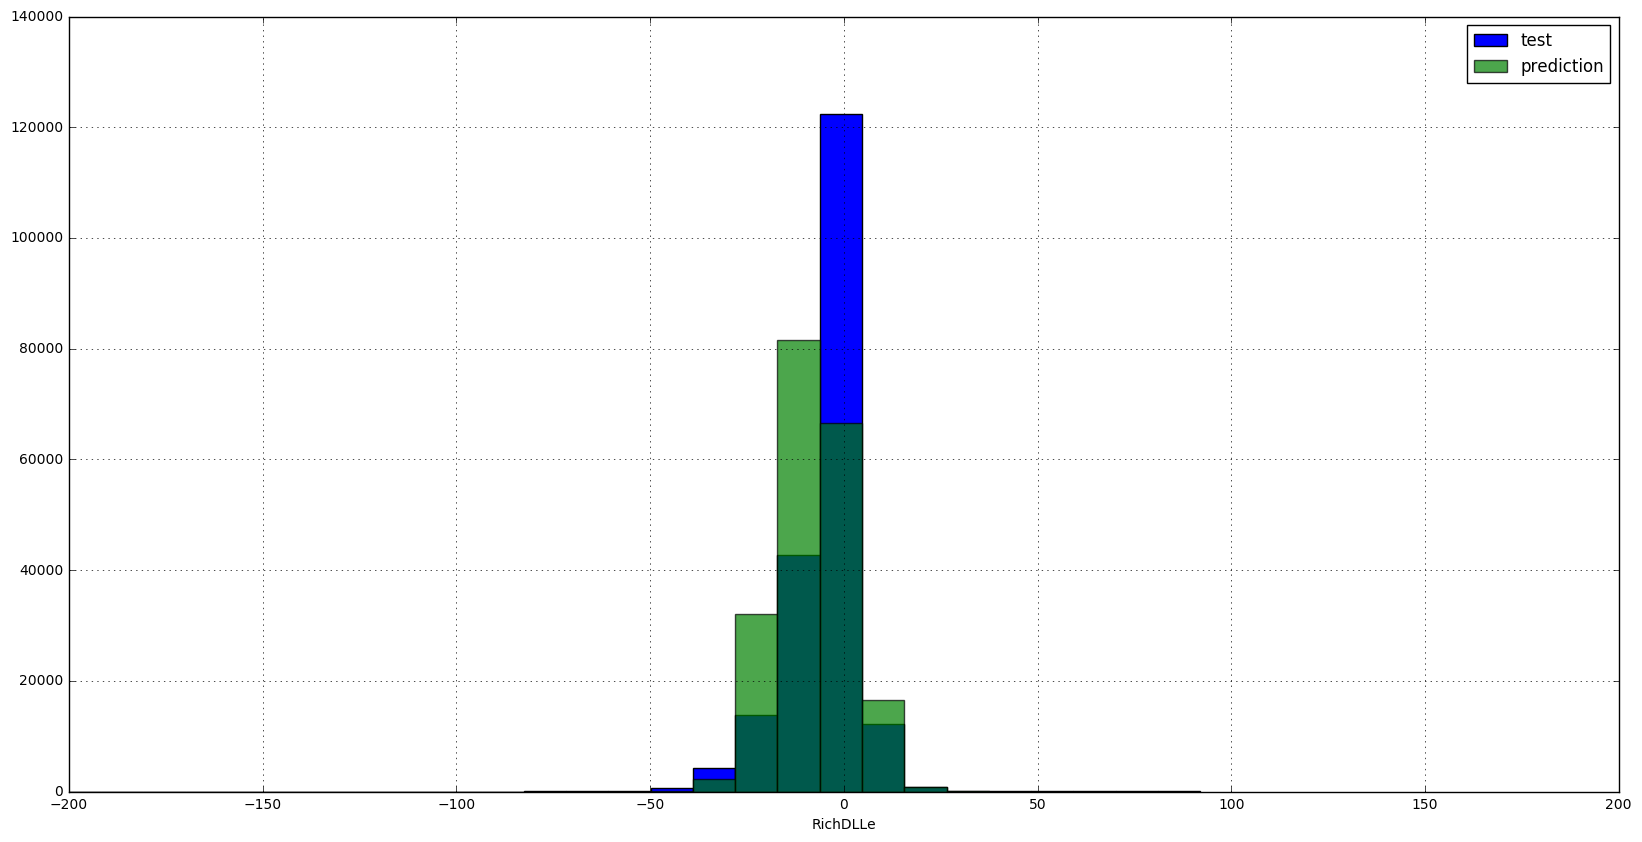

In [18]:
for col in Y_pred.columns:
    plt.subplots(figsize=(20, 10))
    plt.grid()
    _, bins, _ = plt.hist(Y_test[col], bins=100 , label='test'      )
    _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
    plt.legend(loc='best')
    plt.xlim(left=-200)
    plt.xlabel(col)
    plt.show();

# muon

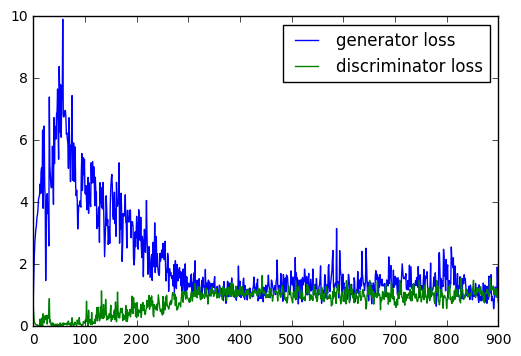

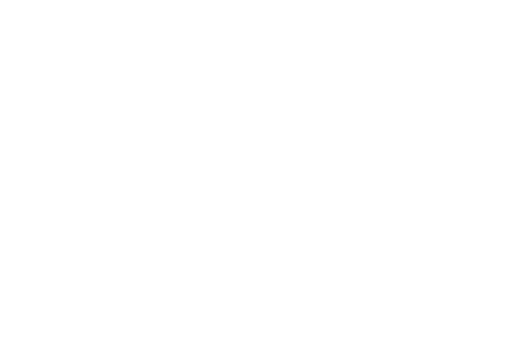

In [34]:
df_pion = pd.read_csv('data/v1_pion_train.csv')

logsigmoid = torch.nn.functional.logsigmoid

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dims, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 5),
    #torch.nn.ELU(),
)#.cuda()

discriminator = torch.nn.Sequential(
    torch.nn.Linear(5, 128),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(128, 256),
    torch.nn.ELU(),
    torch.nn.Dropout(p=dropout_rate),
    torch.nn.Linear(256, 1),
)#.cuda()

def generator_loss(fake):
    return -torch.mean(logsigmoid(discriminator(fake)))
  
def discriminator_loss(real, fake):
    return -torch.mean(logsigmoid(discriminator(real)))-torch.mean(logsigmoid(-discriminator(fake)))

batch_size = 32

def sample_responses(batch_size):
    ids = np.random.choice(len(df_pion), size=batch_size)
    return torch.tensor(np.array(df_pion[y_cols])[ids])#.cuda()

def sample_fake(batch_size):
    noise = torch.randn(batch_size, latent_dims)#.cuda()
    return generator(noise)

generator_losses = []
discriminator_losses = []

optimizer_generator = \
    torch.optim.Adam(generator.parameters())
optimizer_discriminator = \
    torch.optim.SGD(discriminator.parameters(), lr = 0.01, momentum=0.8)
    
for i in range(1000):
    # Set our models to training mode:
    generator.train()
    discriminator.train()
  
    # Several discriminator updates per step:
    for j in range(5):
        # Sampling reals and fakes
        real = sample_responses(batch_size)
        fake = sample_fake(batch_size)
        #print(real.shape, fake.shape)
    
        # Calculating the loss
        loss = discriminator_loss(real.float(), fake.float())
    
        # Doing our regular optimization step for the discriminator
        discriminator.zero_grad()
        loss.backward()
        optimizer_discriminator.step()

    # Remember the value of discriminator loss for plotting
    discriminator_losses.append(loss.item())

    # Now it's generator's time to learn:
    loss = generator_loss(sample_fake(batch_size))
    generator_losses.append(loss.item())
    generator.zero_grad()
    loss.backward()
    optimizer_generator.step()
    #scheduler_d.step()
    #scheduler_g.step()

    
    if i % 100 == 0:
        clear_output(wait=True)
        plt.plot(generator_losses    , label='generator loss')
        plt.plot(discriminator_losses, label='discriminator loss')
        plt.legend()
        plt.show()
        generator.eval()
        #imgs = sample_fake(25).cpu().detach().numpy()
        #plt.figure(figsize=(8, 8))
        #plot_mn(imgs.clip(0, 1))
        plt.axis('off')
        plt.show()

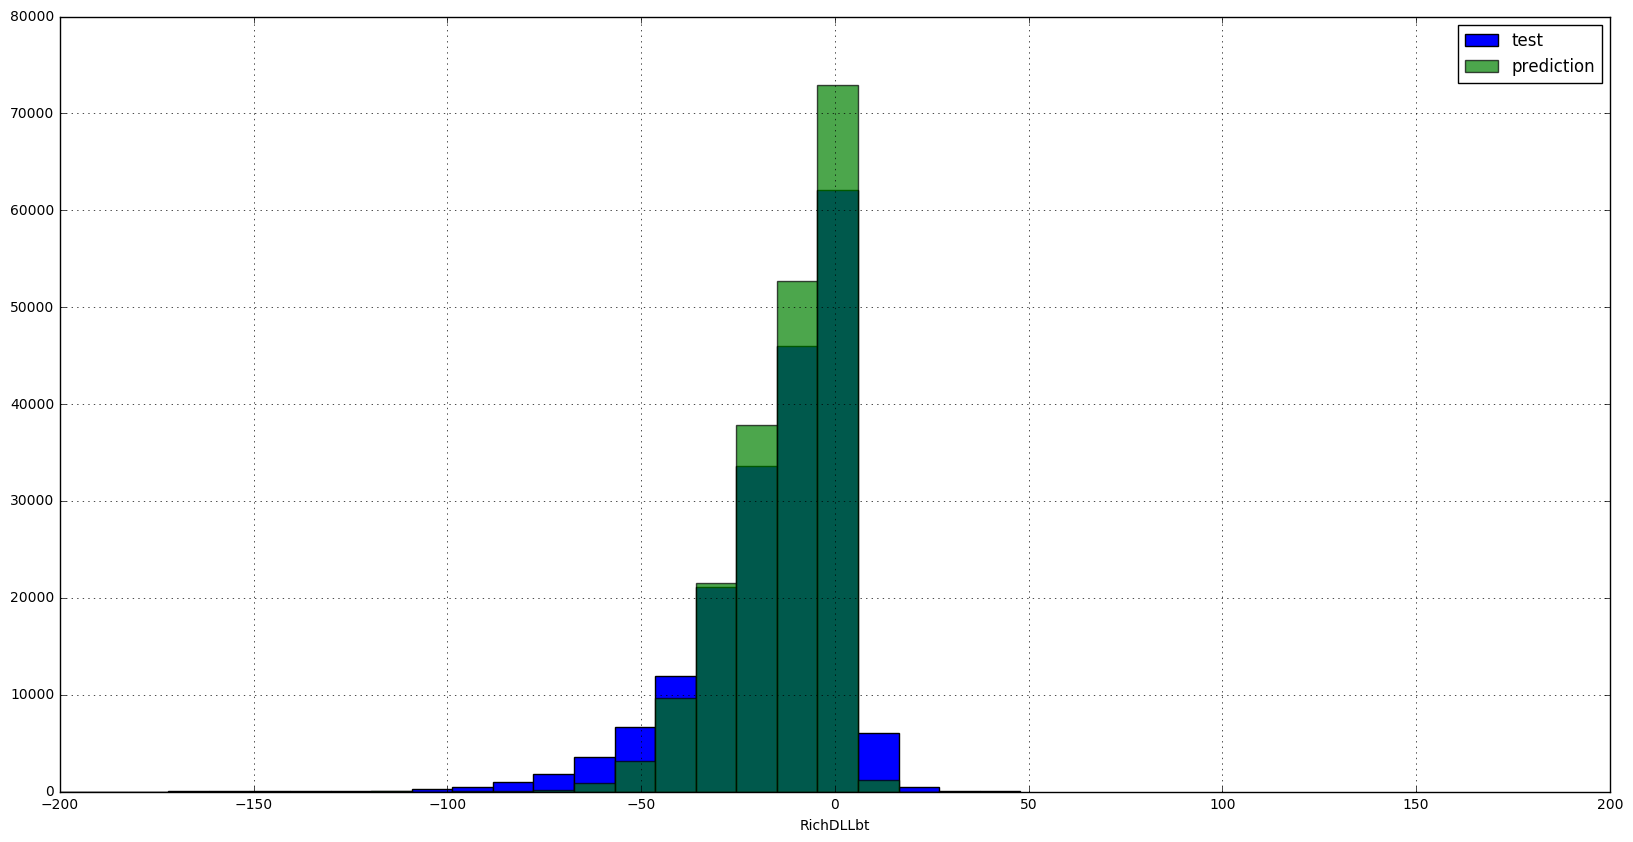

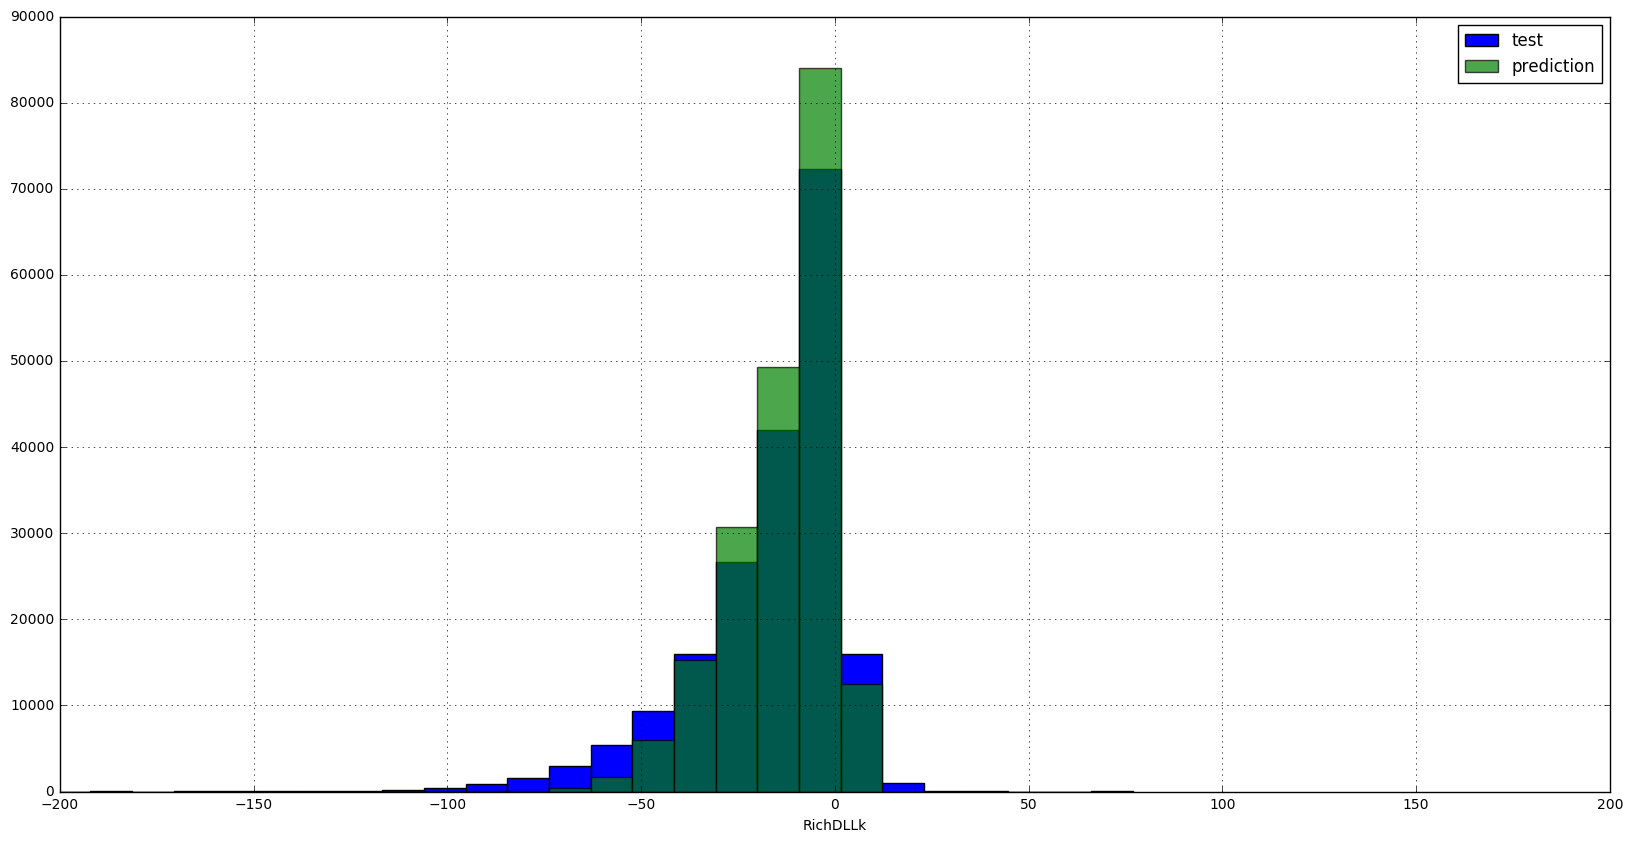

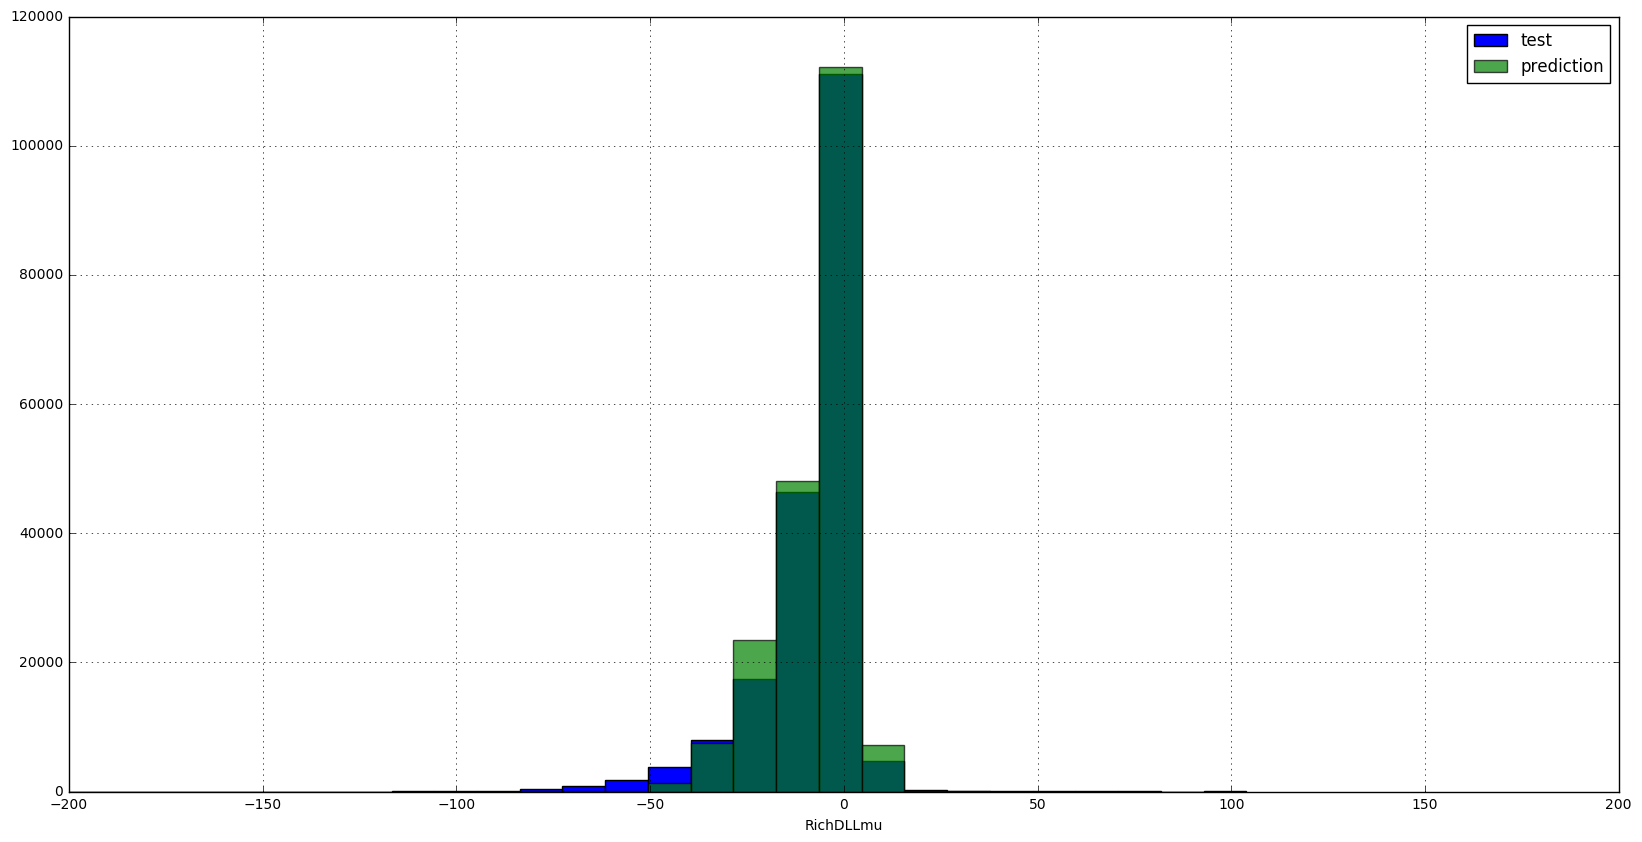

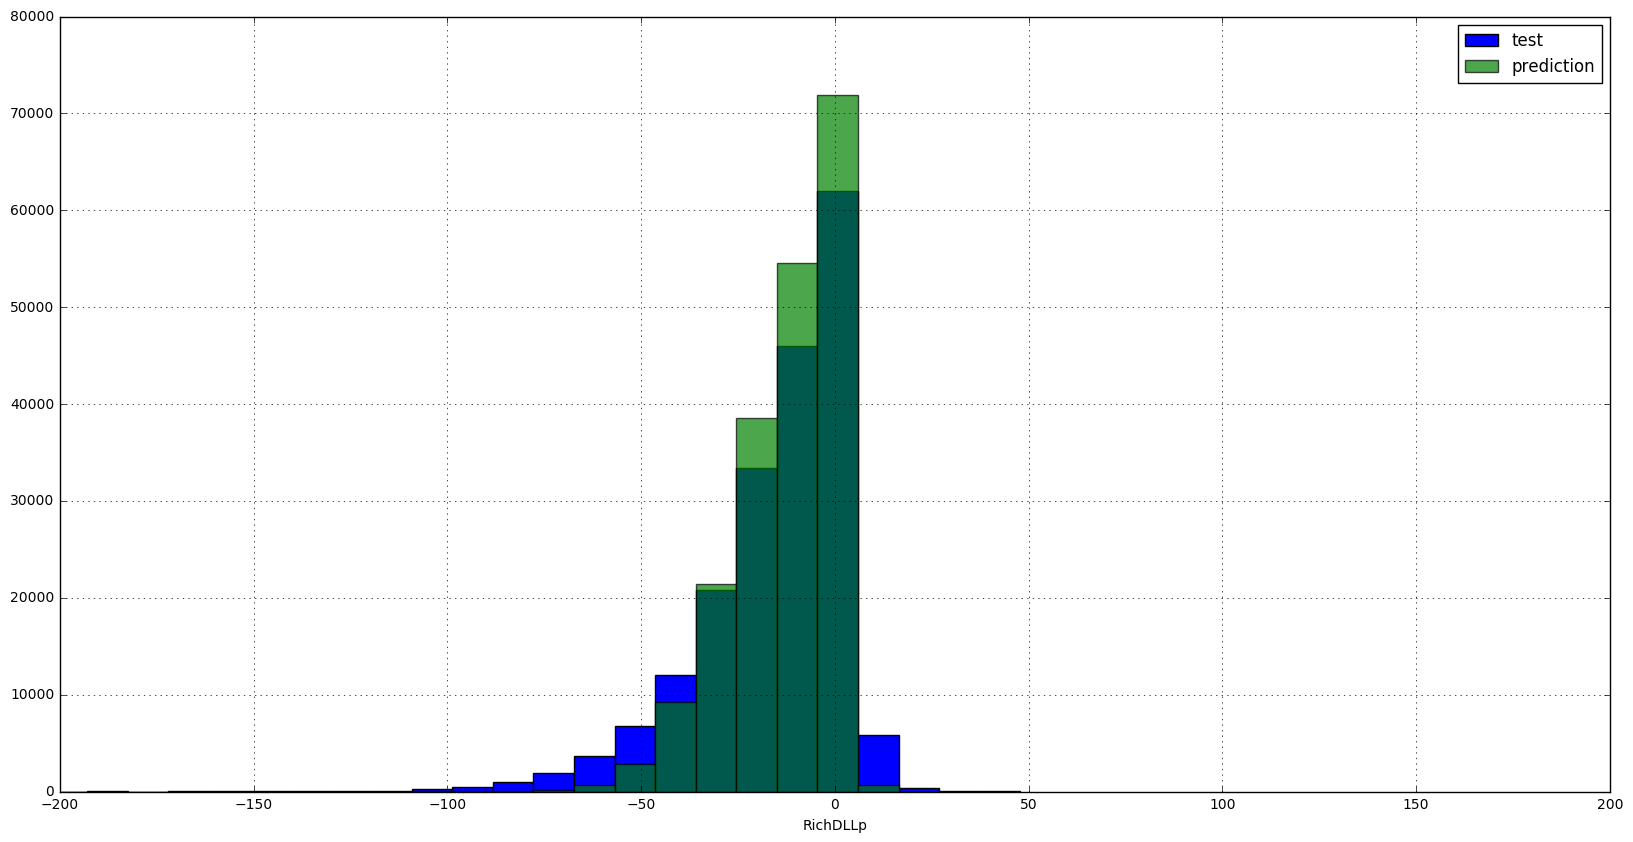

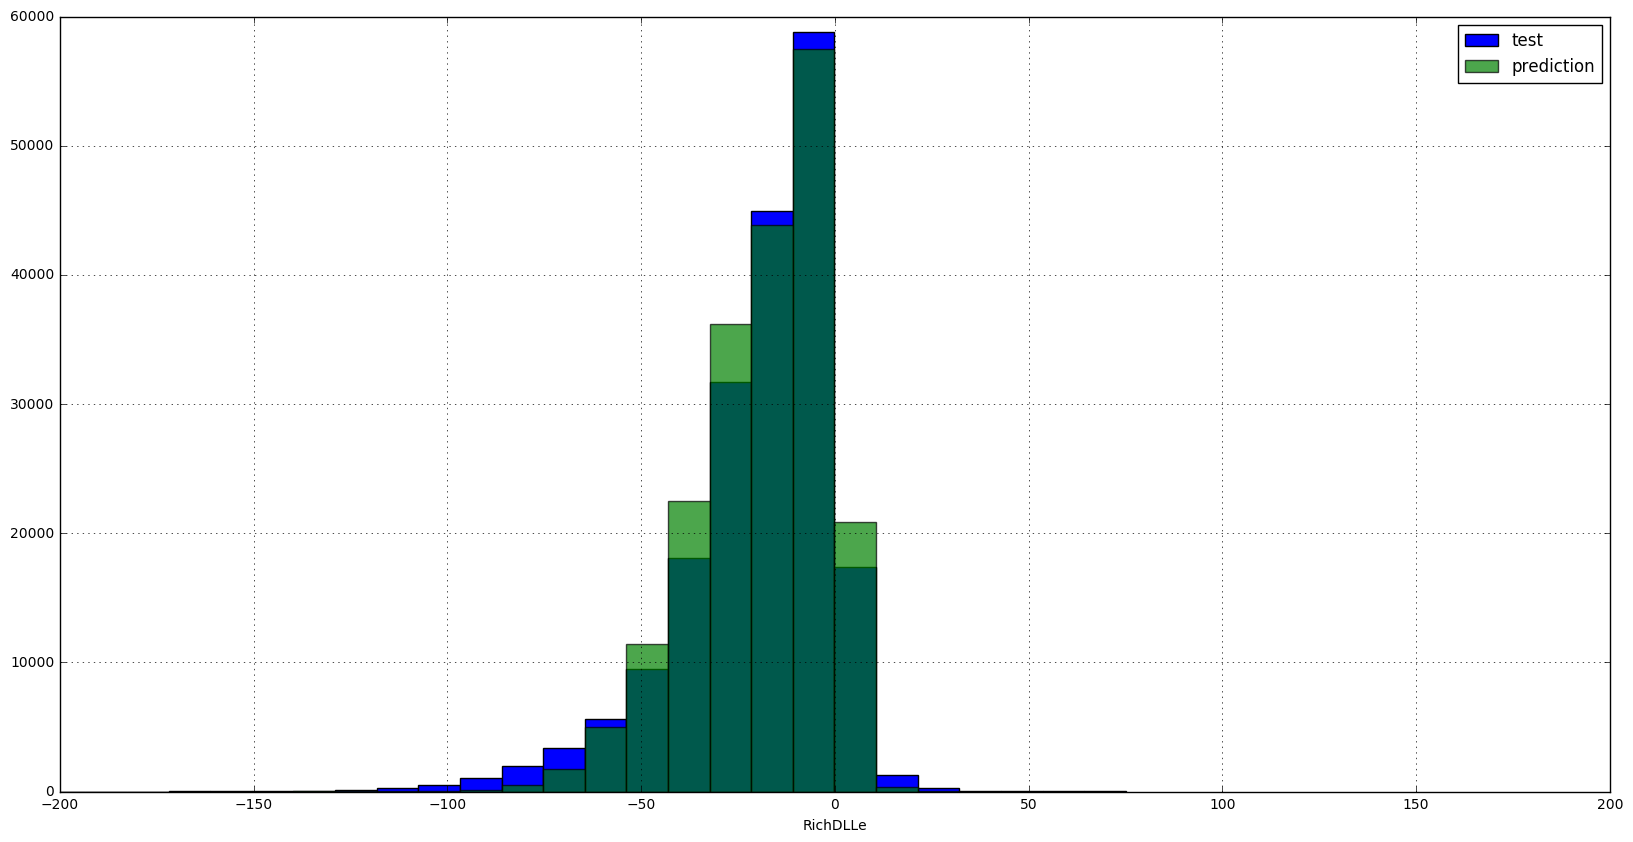

In [35]:
kf = KFold(n_splits=5)

model_scores = []
best_scores  = []

for train_index, test_index in kf.split(df_kaon[x_cols]):
    X_train = df_pion[x_cols].iloc[train_index]
    Y_train = df_pion[y_cols].iloc[train_index]
    X_test  = df_pion[x_cols].iloc[test_index ]
    Y_test  = df_pion[y_cols].iloc[test_index ]
  
    #model = Model()
    #model.train(X_train.copy(), Y_train.copy(), n_bins=5)
    Y_pred = sample_fake(len(X_test))#model.predict(X_test.copy())
    Y_pred = pd.DataFrame(data=Y_pred.detach().numpy(), columns=y_cols)
    model_scores.append(score_func(Y_test, Y_pred))
    best_scores.append(score_func(Y_test, Y_train))
    
for col in Y_pred.columns:
    plt.subplots(figsize=(20, 10))
    plt.grid()
    _, bins, _ = plt.hist(Y_test[col], bins=100 , label='test'      )
    _, _   , _ = plt.hist(Y_pred[col], bins=bins, label='prediction', alpha=0.7)
    plt.legend(loc='best')
    plt.xlim(left=-200)
    plt.xlabel(col)
    plt.show();